In [ ]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd


class MF(nn.Module):
    def __init__(self, n_coeffs, n_comps, n_pix):
        super(MF, self).__init__()
        self.cfs = nn.Parameter(torch.rand(n_coeffs, n_comps, requires_grad=True))
        self.cmps = nn.Parameter(torch.rand(n_comps, n_pix, requires_grad=True))

    def forward(self):
        return torch.matmul(self.cfs,self.cmps)


stack = np.load("stack.npy")
ncomps = 12

pca = PCA(n_components=ncomps).fit(stack)
coeffs = pca.transform(stack)
pca_decomp = pca.inverse_transform(coeffs)

print(pca_decomp.shape, stack.shape)
print(np.mean(np.square(pca_decomp - stack)), np.mean(np.abs(pca_decomp - stack)))


stack_mean = np.mean(stack, axis=0)
target = torch.from_numpy(stack-stack_mean).float().to(device)
print("AAAA", torch.mean(target), torch.std(target))

ncoeffs = stack.shape[0]
npix = 160000

net = MF(ncoeffs, ncomps, npix)
net.to(device)

mse = nn.MSELoss(reduction='mean')
#mse = nn.L1Loss(reduction='mean')
    
opt = optim.AdamW(net.parameters(), lr=1.0)
def unit_norm(cmps):
    return torch.sum(torch.abs(torch.norm(cmps, dim=1) - (torch.ones(12)*20).to(device)))

λ = 1e-6
μ = 1e-9

n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    
    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20
    
print(torch.norm(net.cmps, dim=1))
print(torch.sum(torch.norm(net.cmps, dim=1)))
      
opt = optim.AdamW(net.parameters(), lr=0.001)
n_epoch  = 1000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) #+ λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)
    
    if epoch == 0:
        print(loss.item(), unit_norm(net.cmps).item())

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    
    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

with torch.no_grad():
    net.cfs.data = net.cfs.data*torch.norm(net.cmps, dim=1).data/20
    net.cmps.data = net.cmps.data/torch.norm(net.cmps, dim=1).data[:,None]*20
    
print(torch.norm(net.cmps, dim=1))
print(torch.sum(torch.norm(net.cmps, dim=1)))

opt = optim.AdamW(net.parameters(), lr=0.01)
n_epoch  = 5000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) + λ*unit_norm(net.cmps) + μ*torch.norm(net.cfs, p=1)
    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    
    if epoch % 100 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

print(torch.norm(net.cmps, dim=1))
print(torch.sum(torch.norm(net.cmps, dim=1)))
    
print("Before", epoch, torch.norm(net.cfs, p=1).item(), torch.norm(net.cmps, dim=1))
print(torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

"""
opt = optim.AdamW(net.parameters(), lr=0.0000001)
n_epoch  = 20000
for epoch in range(n_epoch):
    yhat = net()
    loss = mse(yhat, target) + λ*unit_norm(net.cmps)# + μ*torch.norm(net.cfs, p=1)

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 1000 == 0:
        print(epoch, torch.norm(net.cfs, p=1).item(), mse(yhat, target).item(), unit_norm(net.cmps).item())

print(torch.norm(net.cmps, dim=1))
print(torch.sum(torch.norm(net.cmps, dim=1)))
"""

cuda:0
(497, 160000) (497, 160000)
5.552699591792943e-05 0.004849596741988717
AAAA tensor(7.6754e-13, device='cuda:0') tensor(0.0781, device='cuda:0')
0 2984.61767578125 9.807709693908691 2543.114013671875
100 485.1282958984375 0.0005129173514433205 151.08050537109375
200 425.9569091796875 0.0001900896750157699 183.19638061523438
300 436.1392822265625 0.000137758266646415 190.46905517578125
400 446.56121826171875 0.00010960351937683299 193.75746154785156
500 454.20068359375 9.348282037535682e-05 195.86468505859375
600 458.69940185546875 8.513259672326967e-05 199.77401733398438
700 465.3161315917969 7.474468293366954e-05 206.53152465820312
800 469.13494873046875 7.007846579654142e-05 211.4683837890625
900 471.9873046875 6.638099875999615e-05 215.3974609375
tensor([20.0000, 20.0000, 20.0000, 20.0000, 20.0000, 20.0000, 20.0000, 20.0000,
        20.0000, 20.0000, 20.0000, 20.0000], device='cuda:0',
       grad_fn=<CopyBackwards>)
tensor(240., device='cuda:0', grad_fn=<SumBackward0>)
6.2133

In [55]:

net.cfs.weight = net.cfs.weight*torch.norm(net.cmps, dim=1).data
net.cmps.weight = net.cmps.weight/torch.norm(net.cmps, dim=1).data[:,None]

TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'cfs' (torch.nn.Parameter or None expected)

In [61]:
torch.norm(net.cmps, dim=1).data

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000], device='cuda:0')

In [62]:
yhat = net()
mse(yhat, target)

tensor(5.5527e-05, device='cuda:0', grad_fn=<MseLossBackward>)

In [51]:
net.cfs.weight

tensor([[   4994.9272,   56274.1562,  -42436.0391,  ...,   27049.9707,
           90085.8047, -206003.9844],
        [   4780.3325,   59427.1289,  -35032.6367,  ...,   15990.0518,
           87311.2656, -218886.7812],
        [   3813.2000,   53635.4141,  -41615.8398,  ...,   30051.3945,
           88588.2422, -245695.6719],
        ...,
        [   4590.7021,   65094.7266,     569.1168,  ...,   16818.1738,
          -42576.0898,  106637.0703],
        [   4838.8877,   67151.3125,   44414.5430,  ...,    7364.0806,
          -45842.7031,  274446.6875],
        [   4384.0835,   67558.7656,   15905.0098,  ...,   12992.8926,
          -36506.2812,   84181.1797]], device='cuda:0')

In [76]:
opt = optim.AdamW(net.parameters(), lr=0.001)
n_epoch  = 20000
for epoch in range(n_epoch):
    yhat = net()
    #loss = mse(yhat, target) + 0.1*torch.sum(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device))
    loss = mse(yhat, target) + 0.00001*torch.sum(torch.abs(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device)))

    net.zero_grad() # need to clear the old gradients
    loss.backward()
    opt.step()
    if epoch % 1000 == 0:
        print(epoch, mse(yhat, target).item(), torch.sum(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device)).item())

print(torch.norm(net.cmps, dim=1))
print(torch.sum(torch.norm(net.cmps, dim=1)))

0 5.667725781677291e-05 0.09077882766723633
1000 5.701102418242954e-05 0.07571136951446533
2000 5.6431348639307544e-05 0.015191912651062012
3000 5.7609831856098026e-05 0.028436660766601562
4000 5.688090459443629e-05 0.2020031213760376
5000 5.641028837999329e-05 -0.05528402328491211
6000 5.644630073220469e-05 0.0366857647895813
7000 5.6540586228948087e-05 -0.029678046703338623
8000 5.690027683158405e-05 0.03303772211074829
9000 5.668115773005411e-05 0.15060746669769287
10000 5.627240534522571e-05 0.03915137052536011
11000 5.655726999975741e-05 0.07198381423950195
12000 5.6488013797206804e-05 0.08906149864196777
13000 5.6910179409896955e-05 0.09402436017990112
14000 5.676579166902229e-05 0.13174760341644287
15000 5.640212111757137e-05 0.08366835117340088
16000 5.632060128846206e-05 -0.027755439281463623
17000 5.612634413409978e-05 0.01865631341934204
18000 5.6114917242666706e-05 0.01030951738357544
19000 5.654085543937981e-05 0.01699584722518921
tensor([1.0288, 1.0127, 0.9649, 1.0058, 1.

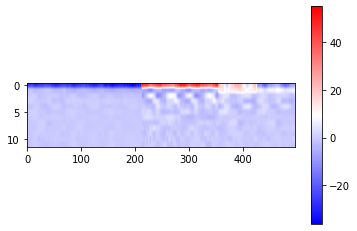

In [80]:
plt.imshow(coeffs.T, aspect=10, cmap='bwr')
plt.colorbar()

array([[ 4.39397610e+05, -6.18456397e-11,  8.86757334e-12,
         0.00000000e+00,  0.00000000e+00, -4.54747351e-13,
        -4.54747351e-13, -4.54747351e-13, -1.81898940e-12,
         2.27373675e-13,  9.94759830e-13, -8.95283847e-13],
       [-6.18456397e-11,  2.30657110e+04,  1.26163968e-10,
        -5.68434189e-13, -5.68434189e-13, -6.25277607e-13,
         4.54747351e-13,  5.11590770e-13,  5.96855898e-13,
        -3.12638804e-13,  2.13162821e-13,  1.56319402e-13],
       [ 8.86757334e-12,  1.26163968e-10,  8.08536217e+03,
         2.88764568e-11, -5.68434189e-13, -5.68434189e-14,
        -7.95807864e-13, -1.77635684e-14, -6.83897383e-14,
         1.70530257e-13,  4.26325641e-14,  5.68434189e-14],
       [ 0.00000000e+00, -5.68434189e-13,  2.88764568e-11,
         3.51020276e+03, -3.41060513e-13,  1.42108547e-13,
        -4.54747351e-13,  4.79616347e-14,  2.84217094e-13,
         1.24344979e-14, -2.41584530e-13,  1.38555833e-13],
       [ 0.00000000e+00, -5.68434189e-13, -5.6843418

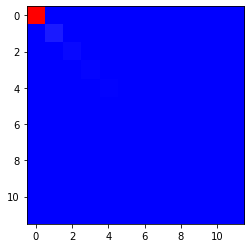

In [74]:
plt.imshow(coeffs.T@coeffs, cmap='bwr')
coeffs.T@coeffs

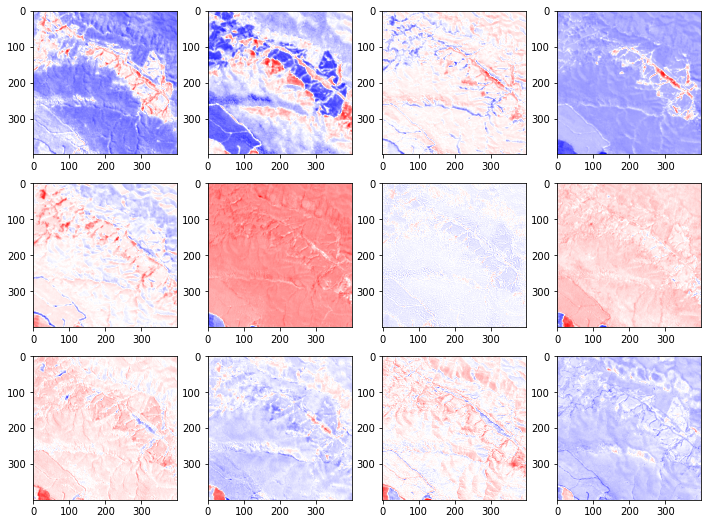

In [36]:
%matplotlib inline

pca_comps = pca.components_.reshape(12,400,400)


fig=plt.figure(figsize=(12, 9))
columns = 4
rows = 3

for i in range(12):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pca_comps[i], cmap='bwr')

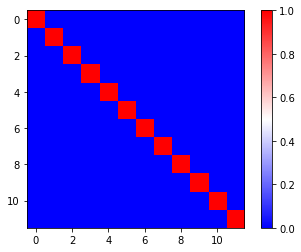

In [21]:
plt.imshow(pca.components_@pca.components_.T, cmap='bwr')
plt.colorbar()

In [29]:
torch.sum(torch.norm(net.cmps, dim=1) - torch.ones(12).to(device))

tensor(278.6743, device='cuda:0', grad_fn=<SumBackward0>)

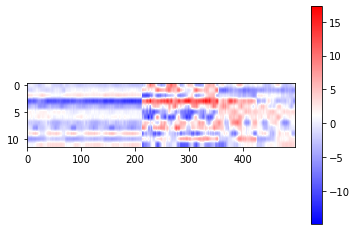

In [79]:
plt.imshow(net.cfs.detach().cpu().numpy().T, aspect=10, cmap='bwr')
plt.colorbar()

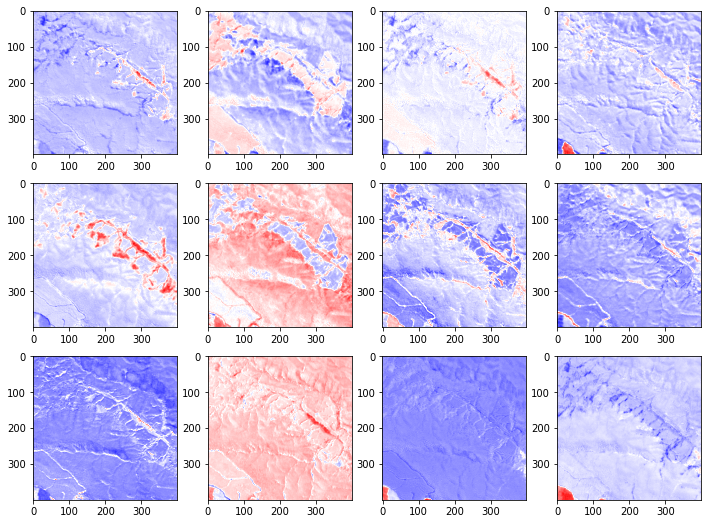

In [78]:
nn_comps = net.cmps.detach().cpu().numpy().reshape(12,400,400)


fig=plt.figure(figsize=(12, 9))
columns = 4
rows = 3

for i in range(12):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(nn_comps[i], cmap='bwr')

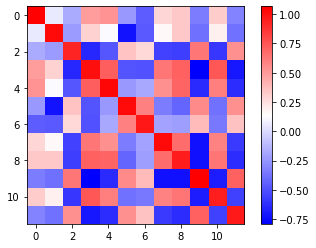

In [77]:
plt.imshow(net.cmps.detach().cpu().numpy()@net.cmps.detach().cpu().numpy().T, cmap='bwr')
plt.colorbar()